In [23]:
%%capture
!pip install transformers
!pip install datasets
!pip install ml_collections
!pip install einops
#!wget https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz

In [24]:
from einops import rearrange

In [53]:
from transformers import AutoImageProcessor, ViTModel, ViTConfig
import torch
from datasets import load_dataset
import glob
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoFeatureExtractor, ResNetForImageClassification, AutoImageProcessor
import torchvision.models as models
import torchvision

# Load ResNet50 model
res_net_model = models.resnet50(pretrained=True)
res_net_model = torch.nn.Sequential(*(list(res_net_model.children())[:-3]))
res_net_model.eval()

configuration = ViTConfig()
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel(configuration).from_pretrained("google/vit-base-patch16-224-in21k", ignore_mismatched_sizes=True)
vit_model = torch.nn.Sequential(*(list(vit_model.children())[:-1]))
vit_model.eval()

Sequential(
  (0): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (1): ViTEncoder(
    (layer): ModuleList(
      (0): ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp -r drive/MyDrive/DNN_project/data .

In [5]:
train_path = "data/train_npz"
test_path = "data/test_vol_h5"
batch_size = 1
slices_list = glob.glob(train_path + "/*")

In [6]:
def show_slice(case_slice):
    X = case_slice['image']
    y = case_slice['label']

    print(X.shape, y.shape)

    plt.subplot(1, 2, 1)
    plt.imshow(X)
    plt.subplot(1, 2, 2)
    plt.imshow(y)
    plt.show()

(512, 512) (512, 512)


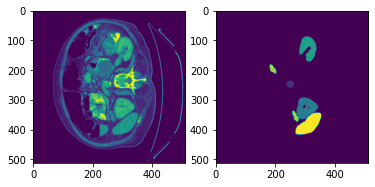

In [7]:
test_slice = np.load(train_path + '/case0005_slice050.npz')

show_slice(test_slice)

In [8]:
train_set_X = []
train_set_y = []

for i, sl in enumerate(slices_list):
    patient_slice = np.load(sl)
    
    train_set_X.append(torch.tensor(np.repeat(np.expand_dims(patient_slice['image'], axis=0), 3, axis = 0)).unsqueeze(0))
    train_set_y.append(torch.tensor(np.repeat(np.expand_dims(patient_slice['label'], axis=0), 3, axis = 0)).unsqueeze(0))


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        dropout = 0.2
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # self.activation = nn.Softmax()

    def forward(self, x):
        return self.conv(x)
        # return self.activation(self.conv(x))



class TransUNet(nn.Module):
    def __init__(self, *, n_channels, n_classes, L=1, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        in_channels = 512
        patch_size = 4
        feature_size = 16

        self.upsampletmp = torch.nn.Upsample(size=(15, 15))

        self.vit = vit_model

        self.resnet = res_net_model

    def forward(self, x):
        print(x.shape)
        with torch.no_grad():
            feature_maps = self.resnet(x)
        # Transformer forward
        # r = torch.nn.functional.pad(x1, (0, 1, 0, 1))

        print(feature_maps.shape)
        feature_maps = feature_maps[0]
        feature_maps = torchvision.transforms.Resize((224, 224))(feature_maps)
        print(feature_maps.shape)                          
        feature_maps = torch.unsqueeze(feature_maps, 1)
        feature_maps = feature_maps.repeat(1, 3, 1, 1)
        print(feature_maps.shape)
        with torch.no_grad():
            vit_pred = self.vit(feature_maps)
        last_hidden_states = vit_pred.last_hidden_state
        print(last_hidden_states.shape)
        last_hidden_states = rearrange(
            last_hidden_states, "b (n1 n2) D -> b D n1 n2", n1=4
        )  # from patches to features"""
        print(last_hidden_states.shape)
        tmp = self.upsampletmp(tmp)

        #         r = self.patch_embedings(r)
        #         r, _ = self.transformer_encoder(r)

        #         r = rearrange(r, "b (n1 n2) D -> b D n1 n2", n1=4)  # from patches to features
        #         r = self.upsampletmp(r)  # Upsample to achive desired size

        x = self.up1(tmp, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

In [57]:
from torch.autograd import Variable
from torch.optim import Adam

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    model = TransUNet(n_channels=1, n_classes=8)
    optimizer = Adam(model.parameters(), lr=0.001)
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i in range(len(train_set_X)):
            
            # get the inputs
            images = train_set_X[i]
            labels = train_set_y[i]
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [58]:
train(1)

The model will be running on cuda:0 device
torch.Size([1, 3, 512, 512])
torch.Size([1, 1024, 32, 32])
torch.Size([1024, 224, 224])
torch.Size([1024, 3, 224, 224])


TypeError: ignored

In [47]:
inputs['pixel_values'][:,0,:,:].unsqueeze(0).shape

torch.Size([1, 1, 224, 224])

In [51]:
print(res_net_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
